In [1]:
import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt

In [2]:
%load_ext Cython

In [3]:
%%cython
'''
Cythonized exact propagation in 2D.  
'''
cimport cython
import numpy as np
cimport numpy as cnp
cdef extern from "complex.h":
    double complex cexp(double complex)
from libc.math cimport sqrt

from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
def exact_prop_2D_cython(cnp.ndarray in_wave,cnp.ndarray out_wave,double L_in,\
                           double L_out, double wavel,double z):
    cdef double pi = 3.14159265359
    cdef int N_in_x = in_wave.shape[0]
    cdef int N_in_y = in_wave.shape[1]
    in_domain_x = np.linspace(-L_in/2,L_in/2,N_in_x)
    in_domain_y = np.linspace(-L_in/2,L_in/2,N_in_y)
    
    cdef int N_out_x = out_wave.shape[0]
    cdef int N_out_y = out_wave.shape[1]
    out_domain_x = np.linspace(-L_out/2,L_out/2,N_out_x)
    out_domain_y = np.linspace(-L_out/2,L_out/2,N_out_y)
    
    cdef double step_in_x = L_in/N_in_x
    cdef double step_in_y = L_in/N_in_y
    
    cdef double x,x1,y,y1,f
    cdef double complex fac = 0.7071067811865476-0.7071067811865476j #np.sqrt(1/1j)
    
    for i in range(N_out_x):
        for j in range(N_out_y):
            for p in range(N_in_x):
                for q in range(N_in_y):
                    x  =  in_domain_x[p]
                    y  =  in_domain_y[q]
                    x1 = out_domain_x[i]
                    y1 = out_domain_y[j]
                    f  = in_wave[p][q]
                    out_wave[i][j] += evaluate(f, pi, wavel, z, x, x1, y, y1)
    out_wave *= (step_in_x/sqrt(wavel*z))*fac
    return

cdef double complex evaluate(double f, double pi, double wavel, double z,\
                             double x, double x1, double y, double y1):
    cdef double complex out = f*(((-1j*pi)/(wavel*z))*((x-x1)**2+(y-y1)**2))
    return f*cexp(out)

In [4]:
#energy = 5000
#wavel = (1240/energy)*10**(-9)
wavel = 0.5*10**(-6)
pi = np.pi
z = 100
N = 250
L_in  = 5e-1

in_wave = np.zeros((N,N))
in_wave[int(N/2)-int(N/8):int(N/2)+int(N/8),int(N/2)-int(N/8):int(N/2)+int(N/8)] = 1
out_wave_exact = np.zeros((N,N),dtype='complex128')

In [5]:
exact_prop_2D_cython(in_wave,out_wave_exact,L_in,L_in,wavel,z)

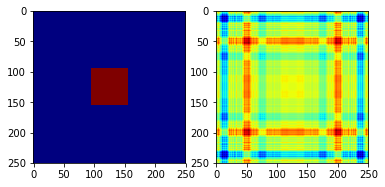

In [6]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(in_wave,cmap='jet')
ax2.imshow(np.abs(out_wave_exact),cmap='jet')
plt.show()